# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from functions import cleaning 

In [2]:
# Disabling a specific type of warning from Jupyter, that I know if mistaken for something else
pd.options.mode.chained_assignment = None 

# Loading dataset

In [3]:
filepath1 = '../Data/df_final_demo.txt' # Client Profiles
filepath2 = '../Data/df_final_web_data_pt_1.txt' # Digital Footprints, part 1
filepath3 = '../Data/df_final_web_data_pt_2.txt' # Digital Footprints, part 2
filepath4 = '../Data/df_final_experiment_clients.txt' # Experiment Roster 

# Loading datasets
df_clients = pd.read_csv(filepath1)
df2 = pd.read_csv(filepath2)
df3 = pd.read_csv(filepath3)
df_roster = pd.read_csv(filepath4)

# Merging part 1 and 2 of Digital Footprints
df_trace = pd.concat([df2, df3], axis=0, ignore_index=True)

# Data cleaning

In [4]:
df_clients, df_trace, df_roster, df_clients_with_na = cleaning(df_clients, df_trace, df_roster)

# Clients' profile

#### Clients' age

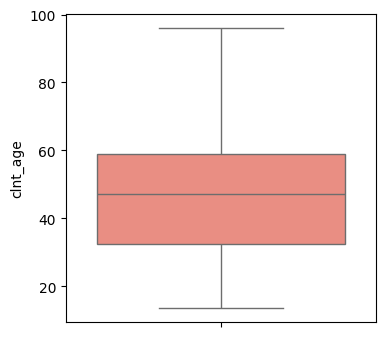

In [5]:
# Box plot with client's age
plt.figure(figsize=(4, 4))
sns.boxplot(data=df_clients['clnt_age'], color='salmon')
plt.show()

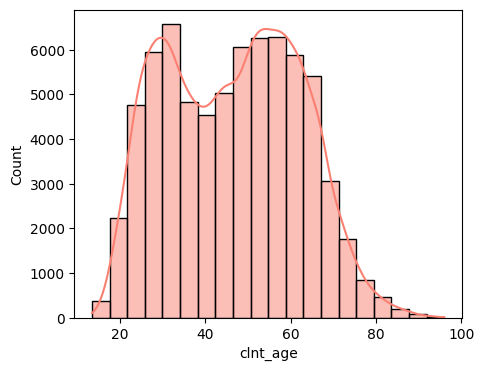

In [15]:
# Histogram with client's age
plt.figure(figsize=(5, 4))
sns.histplot(df_clients['clnt_age'], kde=True, bins=20, color='salmon')
plt.show()

We observe from the boxplot that the clients' age doesn't have outliers.

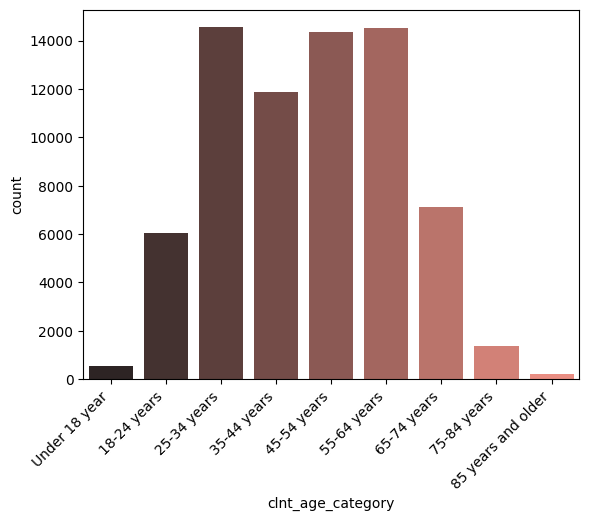

In [7]:
# I want to check the above with some age brackets
bins = [0, 18.0, 25.0, 35.0, 45.0, 55.0, 65.0 , 75.0, 85.0, df_clients['clnt_age'].max()]
labels = ['Under 18 year', '18-24 years', '25-34 years', '35-44 years', '45-54 years', 
          '55-64 years', '65-74 years', '75-84 years', '85 years and older']

df_clients['clnt_age_category'] = pd.cut(df_clients['clnt_age'], bins=bins, labels=labels, include_lowest=True)


# Making a countplot
sns.countplot(data=df_clients, x='clnt_age_category', palette='dark:salmon', hue='clnt_age_category', legend=False)
plt.xticks(rotation=45, ha='right')
plt.show()

It's notable that the clients predominantly fall into two age groups: 25-34 years and 45-64 years. Moreover, the interquartile range (IQR) reinforces this observation, spanning from 32 to 59 years, indicating that the majority of clients are concentrated within this age range.

#### Clients' tenure years

<Axes: xlabel='clnt_tenure_yr', ylabel='Count'>

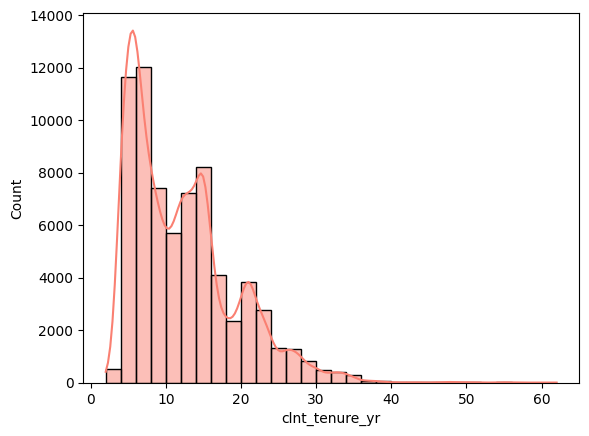

In [8]:
# Histogram with client's tenure years
sns.histplot(df_clients['clnt_tenure_yr'], kde=True, bins=30, color='salmon')

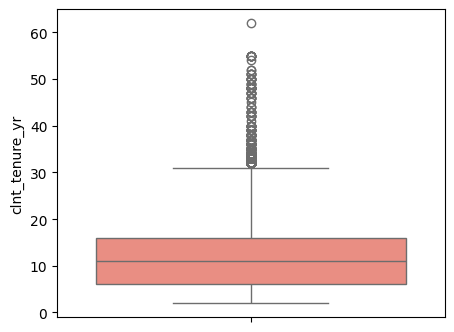

In [9]:
# Box plot with client's tenure years
plt.figure(figsize=(5, 4))
sns.boxplot(data=df_clients['clnt_tenure_yr'], color='salmon')
plt.show()

The distribution of client tenure years is right skewed, and appears to have outliers with higher values. Although outliers are present, in the analysis they will be considered normal, since in the context of an investment management company there can be as long-term clients. The majority of clients have tenures ranging from approximately 6 to 16 years, as indicated by the interquartile range (IQR).

#### Client's gender

Based on the initial exploration, there appears to be a relatively balanced distribution between male and female clients.

#### Interaction with company via call/ platform visit

The vast majority of the clients had some interaction with the company via call or platform visit the last 6 months.

From the intial exploration, with the Pearson correlation analysis, it appears that the most notable linear relationship exists between the number of logins to the site and the number of calls made by the customer within the last 6 months. The Spearman correlation analysis similarly indicates that the strongest association is observed between the number of logins and the number of calls made by customers in the last 6 months, and doesn't reveal any other strong correlation.

# Sample analysis, average time between successful steps

In [10]:
'''
ADD EXPLANATION

analysis specifically done at the visit_id --- to see what the system/ website usually counts as one acive session
before starting counting it as a new session

margin of error of ±1%
99% confidence level
'''

'\nSo, for a 90% confidence level and a margin of error of ±5% : sample size of approximately 271\nADD EXPLANATION\n'

In [11]:
# Specify the number of users t for sample testing
num_users_to_select = 10000

# Select a random sample of users from the client dataframe
sample_users = df_clients['client_id'].sample(n=num_users_to_select, random_state=42)  # Random_state can be adjusted for reproducibility


# Filter the DataFrame to include only the selected users
sample_df = df_trace[df_trace['client_id'].isin(sample_users)]


# Changing step names, sorting dataframe and resseting index, to help with the analysis below
sample_df['process_step'] = sample_df['process_step'].map({'start':1,'step_1':2,'step_2':3,'step_3':4,'confirm':5})
sample_df.sort_values(by=['visit_id','date_time'], ascending=False, inplace=True)
sample_df = sample_df.reset_index(drop=True)

# Adding new columns with previous visit_id, previous process step and previous time, to help with the analysis below
sample_df['previous_visit_id'] = sample_df['visit_id'].shift(-1, fill_value=0)
sample_df['previous_process_step'] = -1
sample_df['previous_date_time'] = '1970-01-01 00:00:00'


# Iterating over each row in the dataframe and checking if the 'visit_id' matches the 'previous_visit_id' in the subsequent row
# If they match, updating the 'previous_process_step' and 'previous_date_time' of the current row with the values from the subsequent row
len_df = sample_df.shape[0]
for i in range(len_df):
    if sample_df.loc[i,'visit_id'] == sample_df.loc[i,'previous_visit_id']:
        sample_df.loc[i,'previous_process_step'] = sample_df.loc[i+1,'process_step']
        sample_df.loc[i,'previous_date_time'] = sample_df.loc[i+1,'date_time']


# Converting to datetime
sample_df['date_time'] = pd.to_datetime(sample_df['date_time'],format='%Y-%m-%d %H:%M:%S')
sample_df['previous_date_time'] = pd.to_datetime(sample_df['previous_date_time'],format='%Y-%m-%d %H:%M:%S')


# Adding a new layer, to check how the current step and the previous step compare
sample_df['subtracting_step'] = sample_df['process_step'] - sample_df['previous_process_step']

# Adding a new layer, to find the time between successful steps, and filter out the ones with no useful info
sample_df['subtracting_date_time'] = sample_df['date_time'] - sample_df['previous_date_time']


# Filtering the sample, to the interactions that moved one step forward == 1
# and excluding the ones that had substraction with the placeholder date '1970-01-01 00:00:00' < 10000 days
filtered_sample_df = sample_df[(sample_df['subtracting_step'] == 1) & (sample_df['subtracting_date_time'] < '10000 days 00:00:00')]

In [73]:
filtered_sample_df['subtracting_date_time'].describe()

count                        37434
mean     0 days 00:01:01.912672971
std      0 days 00:01:40.008641670
min                0 days 00:00:00
25%                0 days 00:00:12
50%                0 days 00:00:32
75%                0 days 00:01:11
max                0 days 00:41:44
Name: subtracting_date_time, dtype: object

In [74]:
filtered_sample_df['subtracting_date_time'].quantile(0.95) #  3 minutes at the 95% percentile

Timedelta('0 days 00:03:29')

#### Defining outliers with IQR method

In [75]:
IQR = filtered_sample_df['subtracting_date_time'].quantile(0.75) - filtered_sample_df['subtracting_date_time'].quantile(0.25)
upper_limit_for_outliers = filtered_sample_df['subtracting_date_time'].quantile(0.75) + IQR
upper_limit_for_outliers

Timedelta('0 days 00:02:10')

#### Defining outliers with Standard Deviation method

In [76]:
filtered_sample_df['subtracting_date_time'].mean() + filtered_sample_df['subtracting_date_time'].std()*3

Timedelta('0 days 00:06:01.938597981')

By this sample analysis, it appears that the average duration for a step forward in the online interaction is approximately 2 minutes, with the majority of the observations(95% percentile) within a range of around 3,5 minutes. To identify outliers, I utilized statistical methods, opting for the Standard Deviation method (multpiplied by 3), which indicates that anything exceeding 6 minutes and 2 seconds should be considered an outlier.  

I will incorporate the identified duration as a threshold to distinguish between sessions in digital footstep analysis. Considering typical intervals between steps of less than the threshold will help determine continuity within sessions versus potential new sessions.

# EDA - Digital footprints

### Two dataframes for 'test' and 'control' group

In [41]:
# Creating two dataframes for the two groups of the test
df_roster_test = df_roster[df_roster.variation == 'Test']
df_roster_control = df_roster[df_roster.variation == 'Control']


# Filtering 
df_test = df_trace[df_trace.client_id.isin(df_roster_test.client_id.unique().tolist())]
df_control = df_trace[df_trace.client_id.isin(df_roster_control.client_id.unique().tolist())]


# Rename column for brevity
df_test = df_test.rename(columns={'process_step': 'step'})
df_control = df_control.rename(columns={'process_step': 'step'})


# Replacing the step names with numbers for analysis purposes, will do subtraction later
df_test['step']  = df_test['step'] .map({'start':1,'step_1':2,'step_2':3,'step_3':4,'confirm':5})
df_control['step']  = df_control['step'] .map({'start':1,'step_1':2,'step_2':3,'step_3':4,'confirm':5})


# Sorting dataframes
df_test.sort_values(by=['client_id','date_time'], ascending=False, inplace=True)
df_control.sort_values(by=['client_id','date_time'], ascending=False, inplace=True)


# Dropping the columns that are not needed for the scope of this sample analysis
df_test.drop(columns=['visitor_id','visit_id'], inplace=True)
df_control.drop(columns=['visitor_id','visit_id'], inplace=True)


# Resetting index
df_test = df_test.reset_index(drop=True)
df_control = df_control.reset_index(drop=True)

### New columns for analysis

In [42]:
# Adding new columns that I will use for comparison: previous  and next client_id
df_test['prev_id'] = df_test['client_id'].shift(-1, fill_value=0)
df_control['prev_id'] = df_control['client_id'].shift(-1, fill_value=0)

df_test['next_id'] = df_test['client_id'].shift(1, fill_value=0)
df_control['next_id'] = df_control['client_id'].shift(1, fill_value=0)


# Adding new columns that I will use for comparison: previous and next step
df_test['prev_step'] = df_test['step'].shift(-1, fill_value=0)
df_control['prev_step'] = df_control['step'].shift(-1, fill_value=0)

df_test['next_step'] = df_test['step'].shift(1, fill_value=0)
df_control['next_step'] = df_control['step'].shift(1, fill_value=0)


# Adding new columns that I will use for comparison: previous datetime, next datetime
df_test['prev_time'] = df_test['date_time'].shift(-1, fill_value='1970-01-01 00:00:00')
df_control['prev_time'] = df_control['date_time'].shift(-1, fill_value='1970-01-01 00:00:00')

df_test['prev_time'] = pd.to_datetime(df_test['prev_time'],format='%Y-%m-%d %H:%M:%S')
df_control['prev_time'] = pd.to_datetime(df_control['prev_time'],format='%Y-%m-%d %H:%M:%S')

df_test['next_time'] = df_test['date_time'].shift(1, fill_value='1970-01-01 00:00:00')
df_control['next_time'] = df_control['date_time'].shift(1, fill_value='1970-01-01 00:00:00')

df_test['next_time'] = pd.to_datetime(df_test['next_time'],format='%Y-%m-%d %H:%M:%S')
df_control['next_time'] = pd.to_datetime(df_control['next_time'],format='%Y-%m-%d %H:%M:%S')


# Adding new columns that I will use for comparison: time difference between current and last step
df_test['time_diff_prev'] = df_test['date_time'] - df_test['prev_time']
df_control['time_diff_prev'] = df_control['date_time'] - df_control['prev_time']


# Adding new columns that I will use for comparison: step duration (difference of following datime with current one)
df_test['time_diff_next'] = df_test['next_time'] - df_test['date_time']
df_control['time_diff_next'] = df_control['next_time'] - df_control['date_time']


# Adding a new layer, to count the steps back, but making sure that I don't compare different clients
df_test['subtract_step'] = np.where(df_test['client_id'] == df_test['prev_id'], 
                                          (df_test['step'] - df_test['prev_step']),0)
df_control['subtract_step'] = np.where(df_control['client_id'] == df_control['prev_id'], 
                                          (df_control['step'] - df_control['prev_step']),0)

### Defining seperate sessions

Conditions:

The conditions aim to identify the start of a new session within a sequence of actions. If the current action is the first step ('start') and either the previous client is different or the time gap between the current and previous step exceeds the threshold of 6 minutes and 2 seconds, it signifies the start of a new session. 

Note: The threshold of 6 minutes and 2 seconds is derived from thesample analysis of the time between steps, completed above in the document. Using the standard deviation method (multiplying by 3), it was determined that anything above 6 minutes and 2 seconds could be considered an outlier. This threshold helps identify significant time gaps between steps indicative of a new session.

In [43]:
# Adding new columns that I will use for comparison: counting the new sessions

df_test['new_session'] = False
df_control['new_session'] = False


# Threshold of 6 min and 2 seconds, result of the sample analysis
threshold_6m = datetime.timedelta(seconds=362) # to be adjusted if needed

conditions = np.array(
    (df_test['step'] == 1) & 
    ((df_test['time_diff_prev'] > threshold_6m) |
    (df_test['client_id'] != df_test['prev_id']))
)
df_test.loc[conditions, 'new_session'] = True


# Doing the same for the 'control' dataframe

conditions = np.array(
    (df_control['step'] == 1) & 
    ((df_control['time_diff_prev'] > threshold_6m) |
    (df_control['client_id'] != df_control['prev_id']))
)
df_control.loc[conditions, 'new_session'] = True


# Sorting everything to ascending order, to help with following steps

df_test.sort_values(by=['client_id','date_time'], ascending=True, inplace=True)
df_control.sort_values(by=['client_id','date_time'], ascending=True, inplace=True)

In [44]:
# Defining seperate sessions

count = 0  # Initialize count outside the function

def session_id(new_session):
    ''' Function to define the seperate sessions'''
    
    global count  # Access the count variable from outside the function
    
    if new_session == True:
        count += 1
        return count       
    else:
        return count


# Calling session_id that is defined in functions.py
df_test['session_id'] = df_test['new_session'].apply(session_id)


# Doing the same for the 'control' dataframe
count = 0  # Resetting count outside the function

df_control['session_id'] = df_control['new_session'].apply(session_id)

###  Filtering invalid sessions

Conditions

Valid Session:
A valid session is characterized by consecutive steps occurring within a duration of no more than 6 minutes.

Invalid Session:
An invalid session is identified when the time interval between consecutive steps exceeds 6 minutes.

Successful Session:
A successful session is a valid session that successfully reaches the 'confirm' stage after traversing all required steps ('start', 'step1', 'step2', 'step3'). In cases of multiple 'confirm' steps, the last one is regarded as the official confirm. Metrics for successful sessions include quantifying the total number of steps taken, the total number of steps taken backward, and calculating the duration from the session start to the final valid confirm step.

Unsuccessful Session:
Unsuccessful session is one that fails to reach the 'confirm' stage completely or reaches 'confirm' without passing through the necessary steps. These sessions may be flagged for further investigation to understand the reasons behind the incomplete or irregular user behavior.

In [45]:
# Variable to count steps until 'confirm'
steps_count = 1
# Variable to count how many steps back there were per session
steps_back = 0
# Variable to count how many valid 'confirms' have been per session
confirm_count = 0
# Variable to check if there are more than 1 'confirm' in the same session
confirmed = False
# Variable to check if the session is valid
valid = True
# Variable to count invalid occurences
invalid_count = 0
# Variables to see if per session steps 1,2,3 were completed before 'confirm'
check_1 = False
check_2 = False
check_3 = False
# Variable to measure how long a session that reached 'confirm' lasted
session_start = '1970-01-01 00:00:00'


def session_info(df):
    # To access the variable from outside the function
    global steps_count 
    global steps_back
    global confirm_count
    global confirmed
    global valid
    global invalid_count
    global check_1
    global check_2
    global check_3
    global session_start

    threshold_6m = datetime.timedelta(seconds=362)
    
    if df['new_session'] == True:
        # Resetting the counts for the new sessions
        steps_count = 1
        steps_back = 0
        confirm_count = 0
        confirmed = False
        valid = True
        invalid_count = 0
        session_start = df['date_time']
        session_start = pd.to_datetime(session_start,format='%Y-%m-%d %H:%M:%S')
        check_1 = False
        check_2 = False
        checl_3 = False        
        return [confirm_count, steps_count, steps_back, df['time_diff_next'], pd.NaT, invalid_count]

    elif df['time_diff_prev'] < threshold_6m and valid:
        
        if df['step'] in (1,2,3,4):
            if df['step'] == 2:
                check_1 = True
            elif df['step'] == 3:
                check_2 = True
            else:
                check_3 = True
                
            # Counting the steps back
            if df['subtract_step'] < 0:
                steps_back += abs(df['subtract_step'])            
            
            # Counting the total steps
            steps_count += 1

            return [confirm_count, steps_count, steps_back, df['time_diff_next'], pd.NaT, invalid_count]
 
        # At the first valid 'confirm' I am returning the total number of steps
        elif df['step'] == 5 and not confirmed and check_1 and check_2 and check_3:
            confirm_count = 1
            confirmed = True
            steps_count += 1
            session_dur = df['date_time'] - session_start
            return [confirm_count, steps_count, steps_back, pd.NaT, session_dur,invalid_count]
        
        # When more than one 'confirm' happen within the valid timeframe, I need to return the updated info, 
        # and add a step count for the first 'confirm'
        elif df['step'] == 5 and confirmed and check_1 and check_2 and check_3:
            confirm_count += 1
            session_dur = df['date_time'] - session_start
            steps_count += 1
            return [confirm_count, steps_count, steps_back, pd.NaT, session_dur,invalid_count]
    
        # Checking the case where'confirm' is reached without passing from all the necessary steps
        elif df['step'] == 5 and not confirmed:
            # I am considering it a valid session but not a successful one
            # I will count it as an extra step, but that can be defined better later
            steps_count += 1
            return [confirm_count, steps_count, steps_back, df['time_diff_next'], pd.NaT, invalid_count]
    
    elif df['time_diff_prev'] > threshold_6m and valid:
        valid = False
        invalid_count += 1
        return [confirm_count, steps_count, steps_back, pd.NaT, pd.NaT, invalid_count]

    else:
        # this is the case where valid is already False
        invalid_count += 1
        return [confirm_count, steps_count, steps_back, pd.NaT, pd.NaT, invalid_count]

In [46]:
# Applying the above function
df_test['session_info'] = df_test.apply(session_info, axis=1)
df_control['session_info'] = df_control.apply(session_info, axis=1)


# Dropping columns that will not be needed further, saving it to a new dataframe with results
df_test_rslt = df_test.drop(columns=(['time_diff_next','step','date_time','time_diff_prev','subtract_step','new_session',
                       'prev_id','next_id','prev_step','next_step','prev_time','next_time']))
df_control_rslt = df_test.drop(columns=(['time_diff_next','step','date_time','time_diff_prev','subtract_step','new_session',
                       'prev_id','next_id','prev_step','next_step','prev_time','next_time']))


# Splitting the session info in more columns
df_test_rslt[['confirm_cnt', 'steps_cnt', 'steps_back_cnt', 'step_dur',
              'sess_dur_to_confrim','invalid_cnt']] = df_test_rslt['session_info'].apply(pd.Series)
df_control_rslt[['confirm_cnt', 'steps_cnt', 'steps_back_cnt', 'step_dur',
              'sess_dur_to_confrim','invalid_cnt']] = df_test_rslt['session_info'].apply(pd.Series)


# Dropping the session_info column
df_test_rslt = df_test_rslt.drop(columns=('session_info'))
df_control_rslt = df_control_rslt.drop(columns=('session_info'))

# Correctin invalid step_dur, if more than 6min and 2 sec, they are result of subtracting with the next session's time
conditions = (df_test_rslt['step_dur'] > datetime.timedelta(seconds=363)) | (df_test_rslt['step_dur'] < datetime.timedelta(seconds=0))
df_test_rslt.loc[conditions,'step_dur'] = pd.NaT

In [47]:
df_test_rslt.head(30)

,client_id,session_id,confirm_cnt,steps_cnt,steps_back_cnt,step_dur,sess_dur_to_confrim,invalid_cnt
176698,1001101,1,0,1,0,0 days 00:00:13,NaT,0
176697,1001101,1,0,2,0,0 days 00:00:29,NaT,0
176696,1001101,1,0,3,0,0 days 00:00:32,NaT,0
176695,1001101,1,0,4,1,0 days 00:00:26,NaT,0
176694,1001101,1,0,5,1,0 days 00:00:20,NaT,0
176693,1001101,1,0,6,2,0 days 00:00:32,NaT,0
176692,1001101,1,0,7,2,0 days 00:03:32,NaT,0
176691,1001101,1,0,8,4,NaT,NaT,0
176690,1001101,2,0,1,0,0 days 00:00:07,NaT,0
176689,1001101,2,0,2,0,0 days 00:00:27,NaT,0


In [48]:
df_control_rslt.head(30)

,client_id,session_id,confirm_cnt,steps_cnt,steps_back_cnt,step_dur,sess_dur_to_confrim,invalid_cnt
176698,1001101,1,0,1,0,0 days 00:00:13,NaT,0
176697,1001101,1,0,2,0,0 days 00:00:29,NaT,0
176696,1001101,1,0,3,0,0 days 00:00:32,NaT,0
176695,1001101,1,0,4,1,0 days 00:00:26,NaT,0
176694,1001101,1,0,5,1,0 days 00:00:20,NaT,0
176693,1001101,1,0,6,2,0 days 00:00:32,NaT,0
176692,1001101,1,0,7,2,0 days 00:03:32,NaT,0
176691,1001101,1,0,8,4,15 days 22:13:59,NaT,0
176690,1001101,2,0,1,0,0 days 00:00:07,NaT,0
176689,1001101,2,0,2,0,0 days 00:00:27,NaT,0


# Notes etc

In [49]:
df_test_fltrd.groupby('session_id')['valid'].value_counts()

NameError: name 'df_test_fltrd' is not defined

In [ ]:
'''
IN PROGRESS
'''

In [ ]:
# Mean of step duration

In [ ]:
df_test_sess.loc[~(df_test_sess['step_time'] == '0 days 00:00:00'), 'step_time'].mean()

In [ ]:
df_control_sess.loc[~(df_control_sess['step_time'] == '0 days 00:00:00'), 'step_time'].mean()

In [ ]:
'''
IN PROGRESS
'''